## Counteracting misinformation by AI using Deepfake Detection Algorithms

## Team

The four team members are:

- Amol Borkar [GitHub Link](https://github.com/amolbrkr)
- Jash Nimesh Dharia Jaliwala [GitHub Link](https://github.com/JashDharia)
- Austin Rodrigues [GitHub Link](https://github.com/austin-rodrigues)
- Abhishek Shinde [GitHub Link](https://github.com/Abhishek1897)

## Overview

- Our team proposes creating a system that takes images of people’s faces as input and classifies whether the image has been generated or modified by an AI (a.k.a. Deepfakes) system. The advent of easily accessible and realistic generative AI models such as Stable Diffusion presents a significant opportunity for bad actors to abuse manipulated images to impersonate individuals, spread false information, and damage reputations. Therefore, there is a growing need for systems that can differentiate real images from fakes to help prevent misinformation.

- By combining multiple datasets, we are creating a more comprehensive dataset for training our model. This helps the model become more adept at detecting deepfake content, which is critical in today's digital scenery. Exposing the model to various examples and scenarios improves its ability to distinguish between real and fake content. This approach strengthens our model's reliability and adaptability to new types of deepfakes that may emerge in the future.

- The use of a generalised model combining multiple datasets for deepfake detection could significantly aid law enforcement agencies in combating misinformation, fraud, and other illicit activities enabled by deepfakes. They can use this technology to improve their investigative capabilities, identify fraudulent content more efficiently, and potentially prevent crimes like identity theft and online fraud. 
- Additionally, incorporating such a model into social media platforms' content moderation systems could help them maintain trust and safety in their communities by proactively detecting and removing harmful deepfakes. This would help to create a more secure and authentic online environment for their users, while also reducing the spread of misinformation and disinformation.

## Data

We utilized two datasets for our analysis:

1. **Manipulated and Real Faces Dataset**  
   Source: [Zenodo](https://zenodo.org/record/5528418#.YpdlS2hBzDd)  
   Description: This dataset comprises manipulated and real images of faces. The manipulated images depict faces created through various means. We have preprocessed this dataset as outlined in the preprocessing section.

2. **DFDD Dataset**  
   Source: [DFDD Dataset](https://cvlab.cse.msu.edu/dffd-diverse-fake-face-dataset.html)  
   Description: The DFDD dataset contains a collection of real and fake images.  We used this dataset exclusively for modeling purposes.

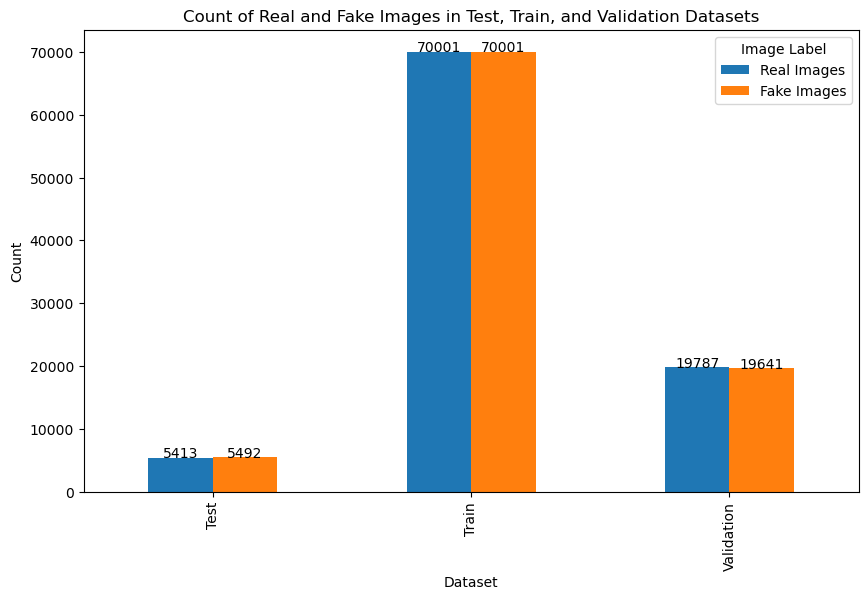

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dataframe for the dataset
data = {
    'Dataset': ['Test', 'Train', 'Validation'],
    'Real Images': [5413, 70001, 19787],
    'Fake Images': [5492, 70001, 19641]
}
df = pd.DataFrame(data)

# Set the 'Dataset' column as the index
df.set_index('Dataset', inplace=True)

# Plot a clustered bar chart
ax = df.plot(kind='bar', figsize=(10, 6))
plt.title('Count of Real and Fake Images in Test, Train, and Validation Datasets')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.legend(title='Image Label')

# Add annotations above each bar
for idx, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, int(height), ha='center')

plt.show()

## Preprocessing

If your data required some preprocessing (surely it did!) document your techniques here.  If this resulted in interesting transformations, you can include examples in code and visualizations to help me understand how the data was transformed.  If you did any sophisticated imputations (e.g. a custom imputation method) feel free to include a code snippet to show me how this was done.

In [ ]:
import cv2
import os

# Load pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Input and output directories
input_dir = '/content/sample_data/Train'
output_dir = 'output_images2/Train/'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Function to process each image in the input directory
def process_images(input_dir, output_dir):
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        if os.path.isdir(category_path):
            output_category_path = os.path.join(output_dir, category)
            if not os.path.exists(output_category_path):
                os.makedirs(output_category_path)
            for filename in os.listdir(category_path):
                if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                    # Read image from file
                    image_path = os.path.join(category_path, filename)
                    img = cv2.imread(image_path)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Detect faces in the image
                    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

                    # If no face detected, skip to next image
                    if len(faces) == 0:
                        print(f"No face detected in {filename}. Skipping...")
                        continue

                    # Crop and resize the face region
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face_resized = cv2.resize(face, (224, 224))

                    # Save cropped face image to output directory
                    output_path = os.path.join(output_category_path, f"{os.path.splitext(filename)[0]}_face.jpg")
                    cv2.imwrite(output_path, face_resized)
                    print(f"Processed {filename} and saved face to {output_path}")

# Process images in the input directory
process_images(input_dir, output_dir)

In [ ]:
import torchvision

IMGWIDTH = 256,

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMGWIDTH, IMGWIDTH)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root="finaldata/", transform=img_transform)

Since, we are working primarily with images, traditional pre-processing techniques such as imputation and outlier removal doesn't apply, instead we performed the following transformations on the images:

1. We take each image (real or fake) and put them in separate folders, so that they can be tracked and loaded with proper labels using PyTorch's ImageLoader API.
2. We then use OpenCV's pre-trained Face Cascade model for detecting faces in the image, we only pick one face in case there are multiple faces present. If no face is found, the image is discarded.
3. We mark a bounding box with a predetermined bounding box around the image and crop everything else beyond this point.
4. Finally, We normalize the image. Normalization in this context means that we take each pixel value of the image which ranges from 0 to 255 and scale it down to a value between -0.5 to 0.5. A lot of models perform well with normalized images.


## Modeling

We have used the AlexNet neural networks which contains 8 layers(convulational and pooling layers) with the RELU activation function to mitigate vanishing gradient problem due to which the gradient becomes small or vanishes in turn the weights and biases cannot update. The architecture starts with an input layer followed by a series of convulational and max pooling layers extracting features like edges and lines and then the max pooling layer reduce the spatial dimensions of the input capturing the most important features.The following stacked multiple convulational layers extracting complex patterns. The three fully connected layers are responsible for taking the feature maps and transformed them into a fixed size vector.The vector in turn is used to output the final predictions.

In [1]:
import torch

class AlexNet(torch.nn.Module):

    def _init_(self, num_classes):
        super()._init_()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

## Problems & Challenges

- Preprocessing a huge data set takes time, which presents a significant challenge from the start. It requires effective strategies for streamlining data preprocessing procedures while preserving data integrity and quality.
- The model needs help in scenarios where face detection becomes complex, primarily due to blurred images. We are considering exploring robust preprocessing techniques or incorporating advanced algorithms capable of effectively handling such scenarios.
- The model's performance is occasionally affected by its inability to detect faces within images, resulting in the loss of useful data. 

## Next steps

Tell me where you are going with the project; what are the next steps, and when do you think they will be done?  Include rough dates! 

1. Given the research we have studied it's apparent that deepfake detection model work well with training data but do not generalize well,to solve this problem we are planning to create a seperate validation set which will contain images generated from five different deepfake generation techniques, this validation set will give us an idea of how well the model generalizes.This will be aggregrated by 1st of April.
2. So far we have tried AlexNet which is an older architecture and more newer and better architecture such as InceptionNet v1, VGGNet architectures exist and compare the performance of two or more models.(7th April)
3. We also will build a web application to the model using Flask framework and dep[loy the model on it].(14th April)


# Grading

- Does your proposal include all of the above mentioned sections? [10 points]
- Are your objectives concrete and do you have a clear stakeholder need? [10 points]
- Do you have a good data source and have you done a thorough job investigating its provenance and credibility? [5 points]
- Did you do a thorough job exploring your data [10 points]
- Have you done some initial modeling of your problem and do you have some early baseline results? [10 points]
- Do you have a clear path forward [5 points]